# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal
import h5py
import time

In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)

#### 1.1. Import the existing TDI datasets

- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

In [5]:
# load xarray dataset containing TDI combinations from LDC dataset
tdi_ts = fid['obs/tdi'][()].squeeze()
# clean data only noise + signal
tdi_clean = fid["clean/tdi"][()].squeeze()
# no noise no glitches, only signal
tdi_sky = fid["sky/tdi"][()].squeeze()
# no noise only glitches and MBHB data
tdi_nonoise = fid["noisefree/tdi"][()].squeeze()

In [6]:
fid['obs/tdi']

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">

#### 1.2. Build the missing TDI dataset
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [7]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdi_ts[skip:])
dt = tdi_ts['t'][1]-tdi_ts['t'][0]
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


In [8]:
# generate noise-only dataset
tdi_noise = np.copy(tdi_clean)
for tdi in tdi_clean.dtype.names[1:]:
    tdi_noise[tdi] = tdi_clean[tdi] - tdi_sky[tdi]

In [9]:
# find all data points included in the gaps
gaps = tdi_ts["t"][np.isnan(tdi_ts["X"])]
# find start times of gaps by taking first point and the point for which 
# the difference between two subsequent samples is more than dt
start = np.hstack([np.array([gaps[0]]), (gaps[1:])[gaps[1:]-gaps[:-1]>dt]])
# same thing with endpoints, but reversed
end = np.hstack([(gaps[:-1])[gaps[1:]-gaps[:-1]>dt], np.array([gaps[-1]])])
# get the indeces for the gaps
gaps_indices = np.vstack([start, end])

# generate gapped dataset
tdi_gapped = np.copy(tdi_clean)
tdi_noise_gapped = np.copy(tdi_noise)
tdi_sky_gapped = np.copy(tdi_sky)

for tdi in tdi_gapped.dtype.names[1:]:
    tdi_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan
    tdi_noise_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan
    tdi_sky_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan

#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

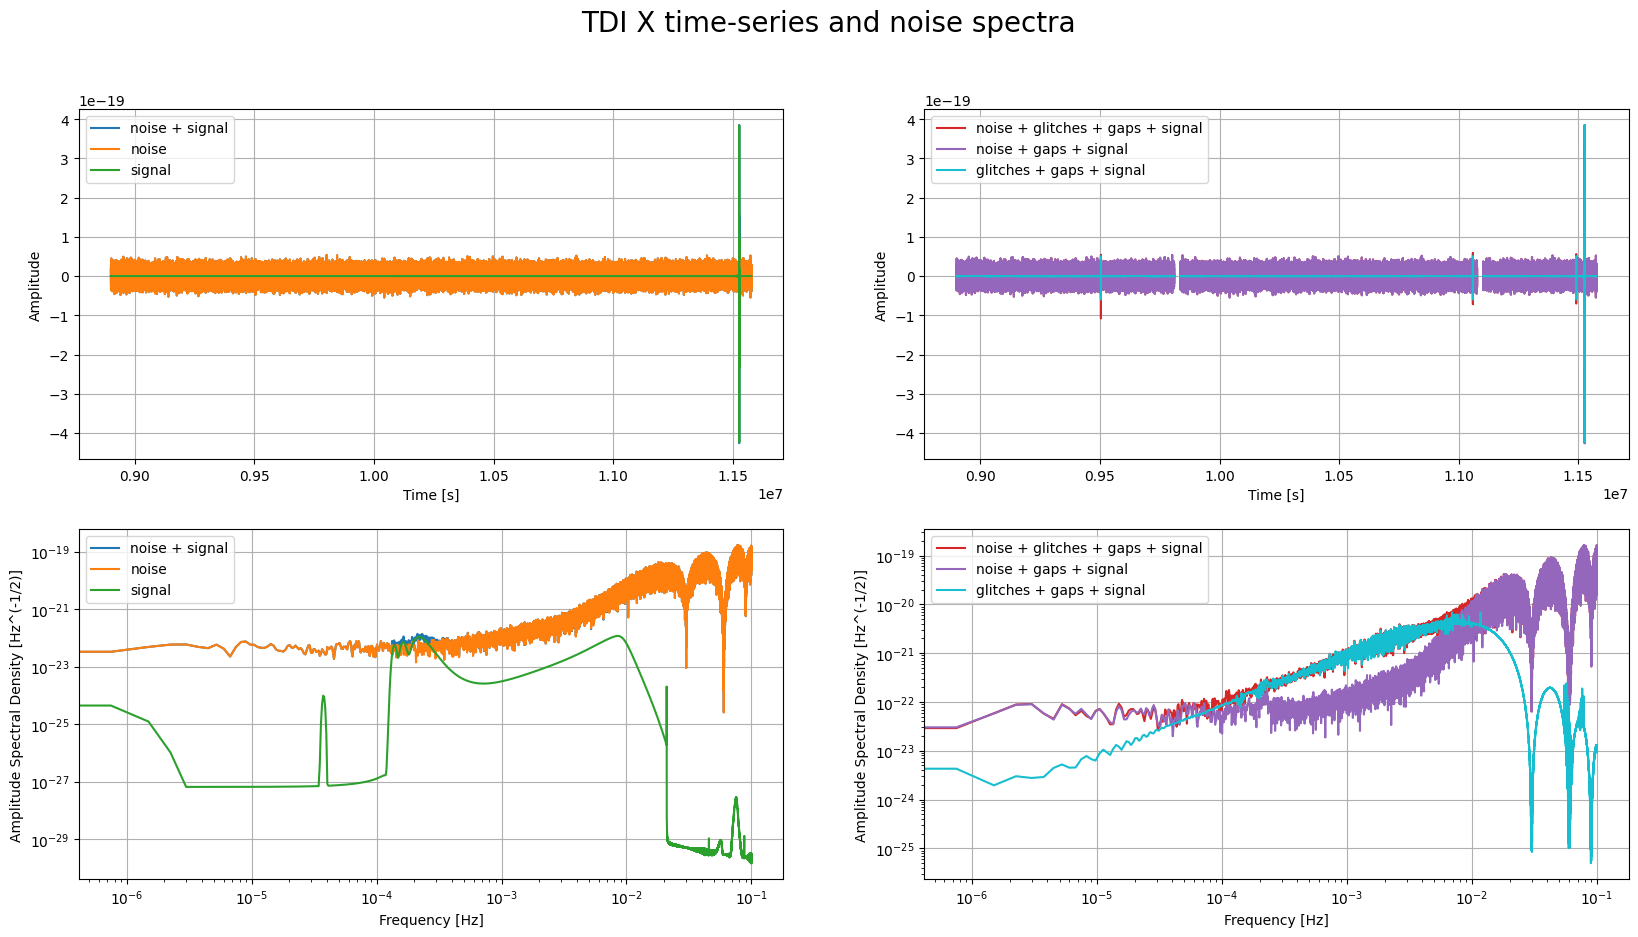

In [10]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdi_clean['t'][skip:], tdi_clean["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdi_noise['t'][skip:], tdi_noise["X"][skip:], label='noise')
ax[0][0].plot(tdi_sky['t'][skip:], tdi_sky["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdi_ts['t'][skip:], tdi_ts["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdi_gapped['t'][skip:], tdi_gapped["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdi_nonoise['t'][skip:], tdi_nonoise["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdi_clean["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdi_noise["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdi_sky["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
# bottom right canvas
tdix_wo_nan = tdi_ts["X"].copy()
tdix_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdi_gapped["X"].copy()
tdigapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdi_nonoise["X"].copy()
tdinoise_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

#### 1.5 Let's take a look at the impact of gaps on the noise spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

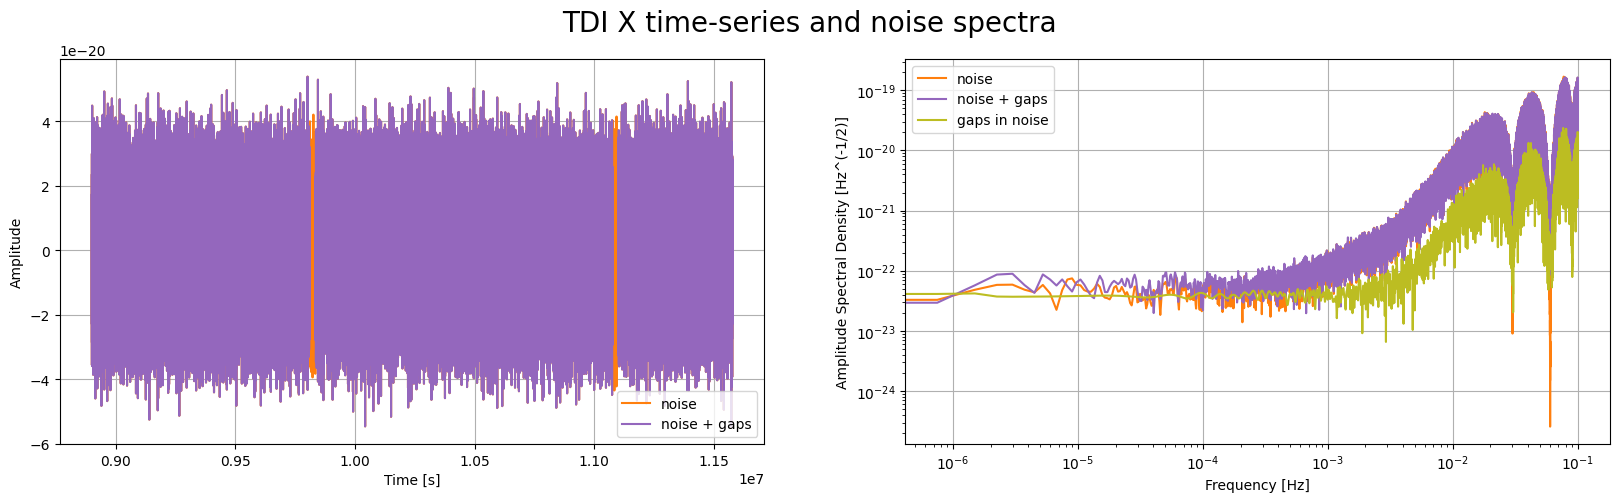

In [11]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi_noise['t'][skip:], tdi_noise["X"][skip:], label='noise', color='tab:orange')
ax[0].plot(tdi_noise_gapped['t'][skip:], tdi_noise_gapped["X"][skip:], label='noise + gaps', color='tab:purple')
# ax[0].plot(tdi_noise_gapped['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdi_noise["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'noise', color='tab:orange')

tdinoisegapped_wo_nan = tdi_noise_gapped["X"].copy()
tdinoisegapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdinoisegapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'noise + gaps', color='tab:purple')

gapdiff = tdinoisegapped_wo_nan[skip:] - tdi_noise["X"][skip:]
f, psddiff =  scipy.signal.welch(gapdiff, fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psddiff),label = 'gaps in noise', color='tab:olive')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

#### 1.6. Let's take a look at the impact of gaps on the signal spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

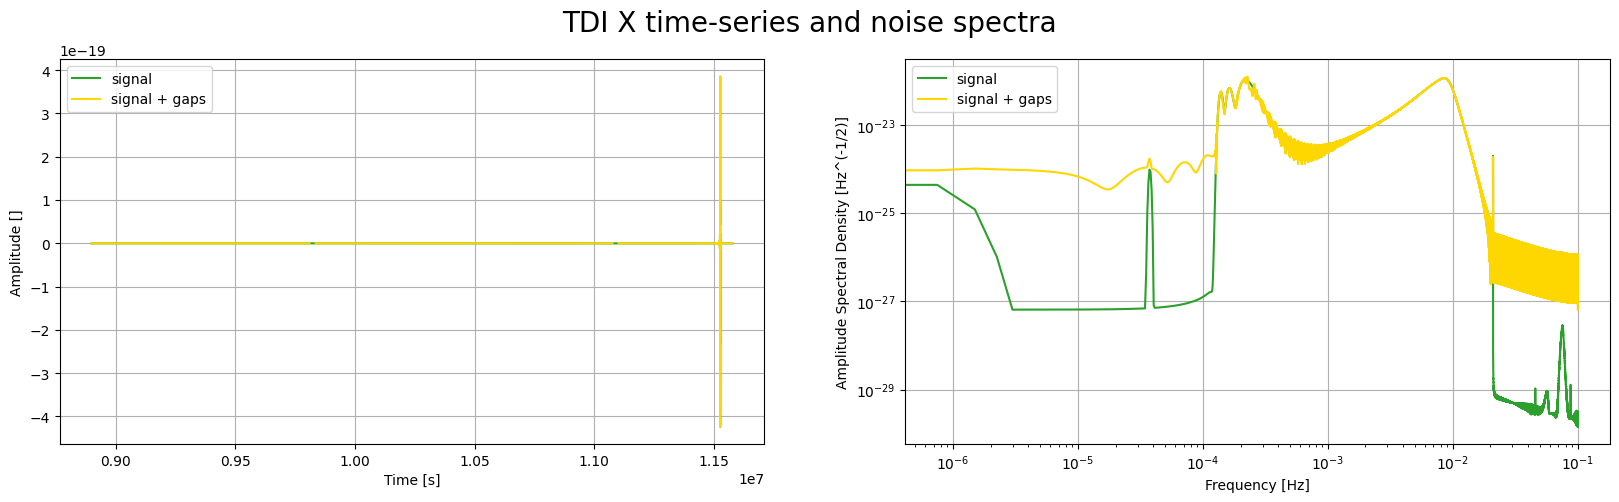

In [12]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi_sky['t'][skip:], tdi_sky["X"][skip:], label='signal', color='tab:green')
ax[0].plot(tdi_sky_gapped['t'][skip:], tdi_sky_gapped["X"][skip:], label='signal + gaps', color='gold')
# ax[0].plot(tdi_noise_gapped['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude []")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdi_sky["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'signal', color='tab:green')

tdiskygapped_wo_nan = tdi_sky_gapped["X"].copy()
tdiskygapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdiskygapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'signal + gaps', color='gold')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [13]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [14]:
datans = build_orthogonal_tdi(tdi_clean)

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

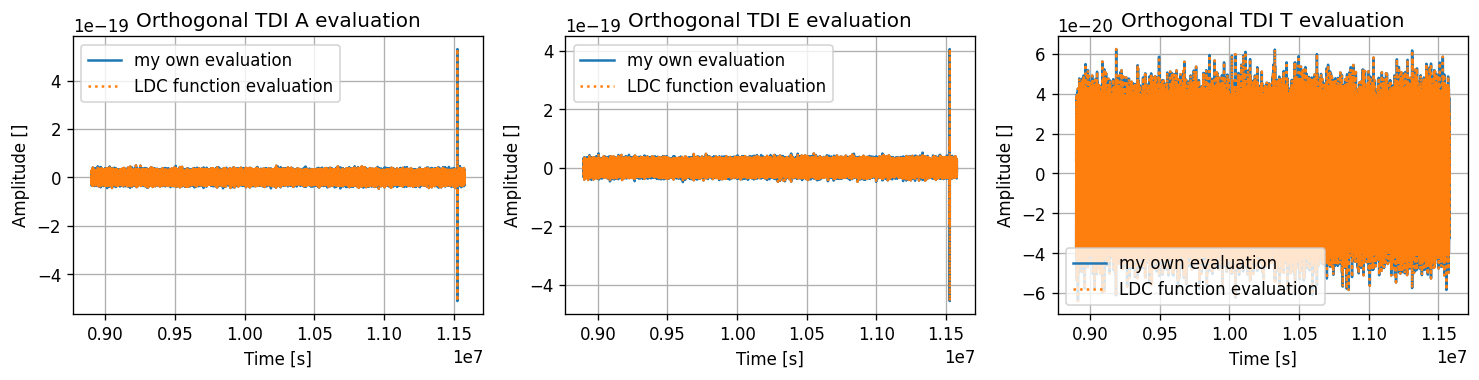

In [15]:
clean_orto = TDI.load(fname, name="clean/tdi")
# clean_orto
clean_orto.XYZ2AET()

fig, ax = plt.subplots(1,3, figsize=(15,3),dpi=120)
for tdi in datans.dtype.names[1:]:
    ax[datans.dtype.names[1:].index(tdi)].set_title('Orthogonal TDI {tdi} evaluation'.format(tdi=tdi))
    ax[datans.dtype.names[1:].index(tdi)].plot(datans['t'], datans[tdi], label = 'my own evaluation')
    ax[datans.dtype.names[1:].index(tdi)].plot(clean_orto[tdi].coords['t'][skip:],clean_orto[tdi].values[skip:], ls =':', label = 'LDC function evaluation')
    ax[datans.dtype.names[1:].index(tdi)].set_xlabel('Time [s]')
    ax[datans.dtype.names[1:].index(tdi)].set_ylabel('Amplitude []')
    ax[datans.dtype.names[1:].index(tdi)].grid()
    ax[datans.dtype.names[1:].index(tdi)].legend()

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [16]:
datas = build_orthogonal_tdi(tdi_sky)
datan = build_orthogonal_tdi(tdi_noise)
datag = build_orthogonal_tdi(tdi_gapped)

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

In [17]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

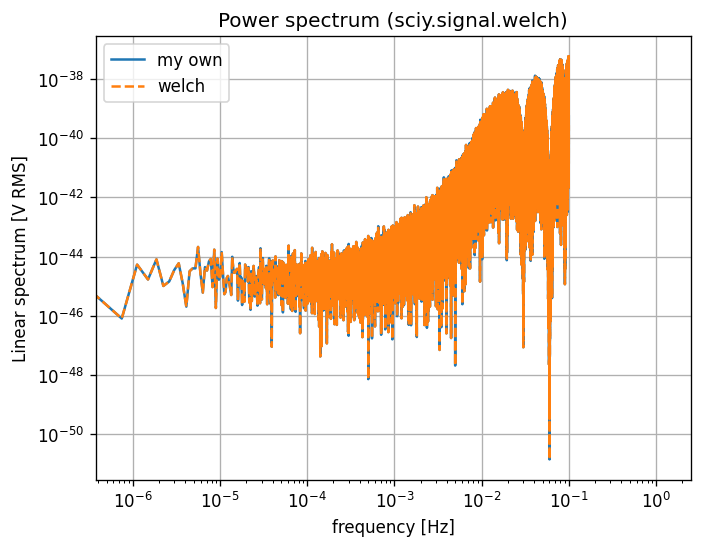

In [18]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(datan, chan = 'A', plot = True)

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

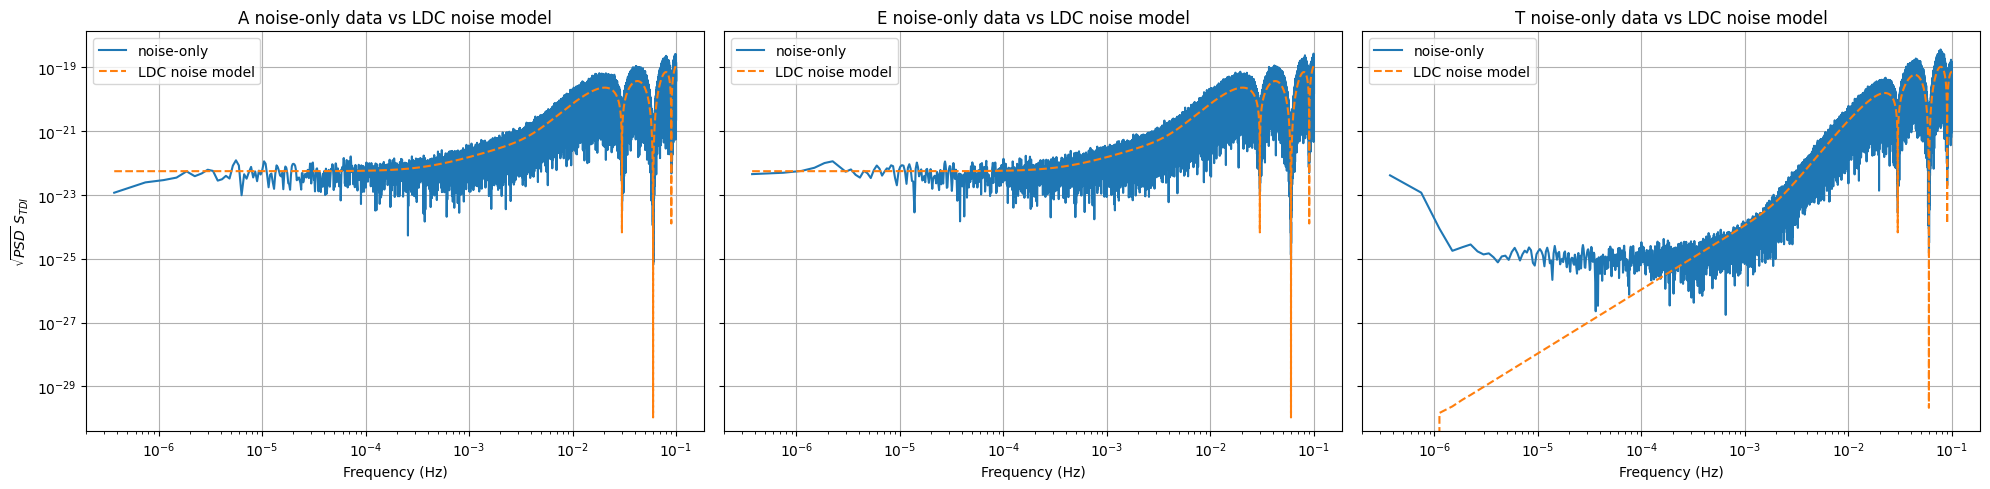

In [19]:
#Load some noise models from lisabeta
# import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'])
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

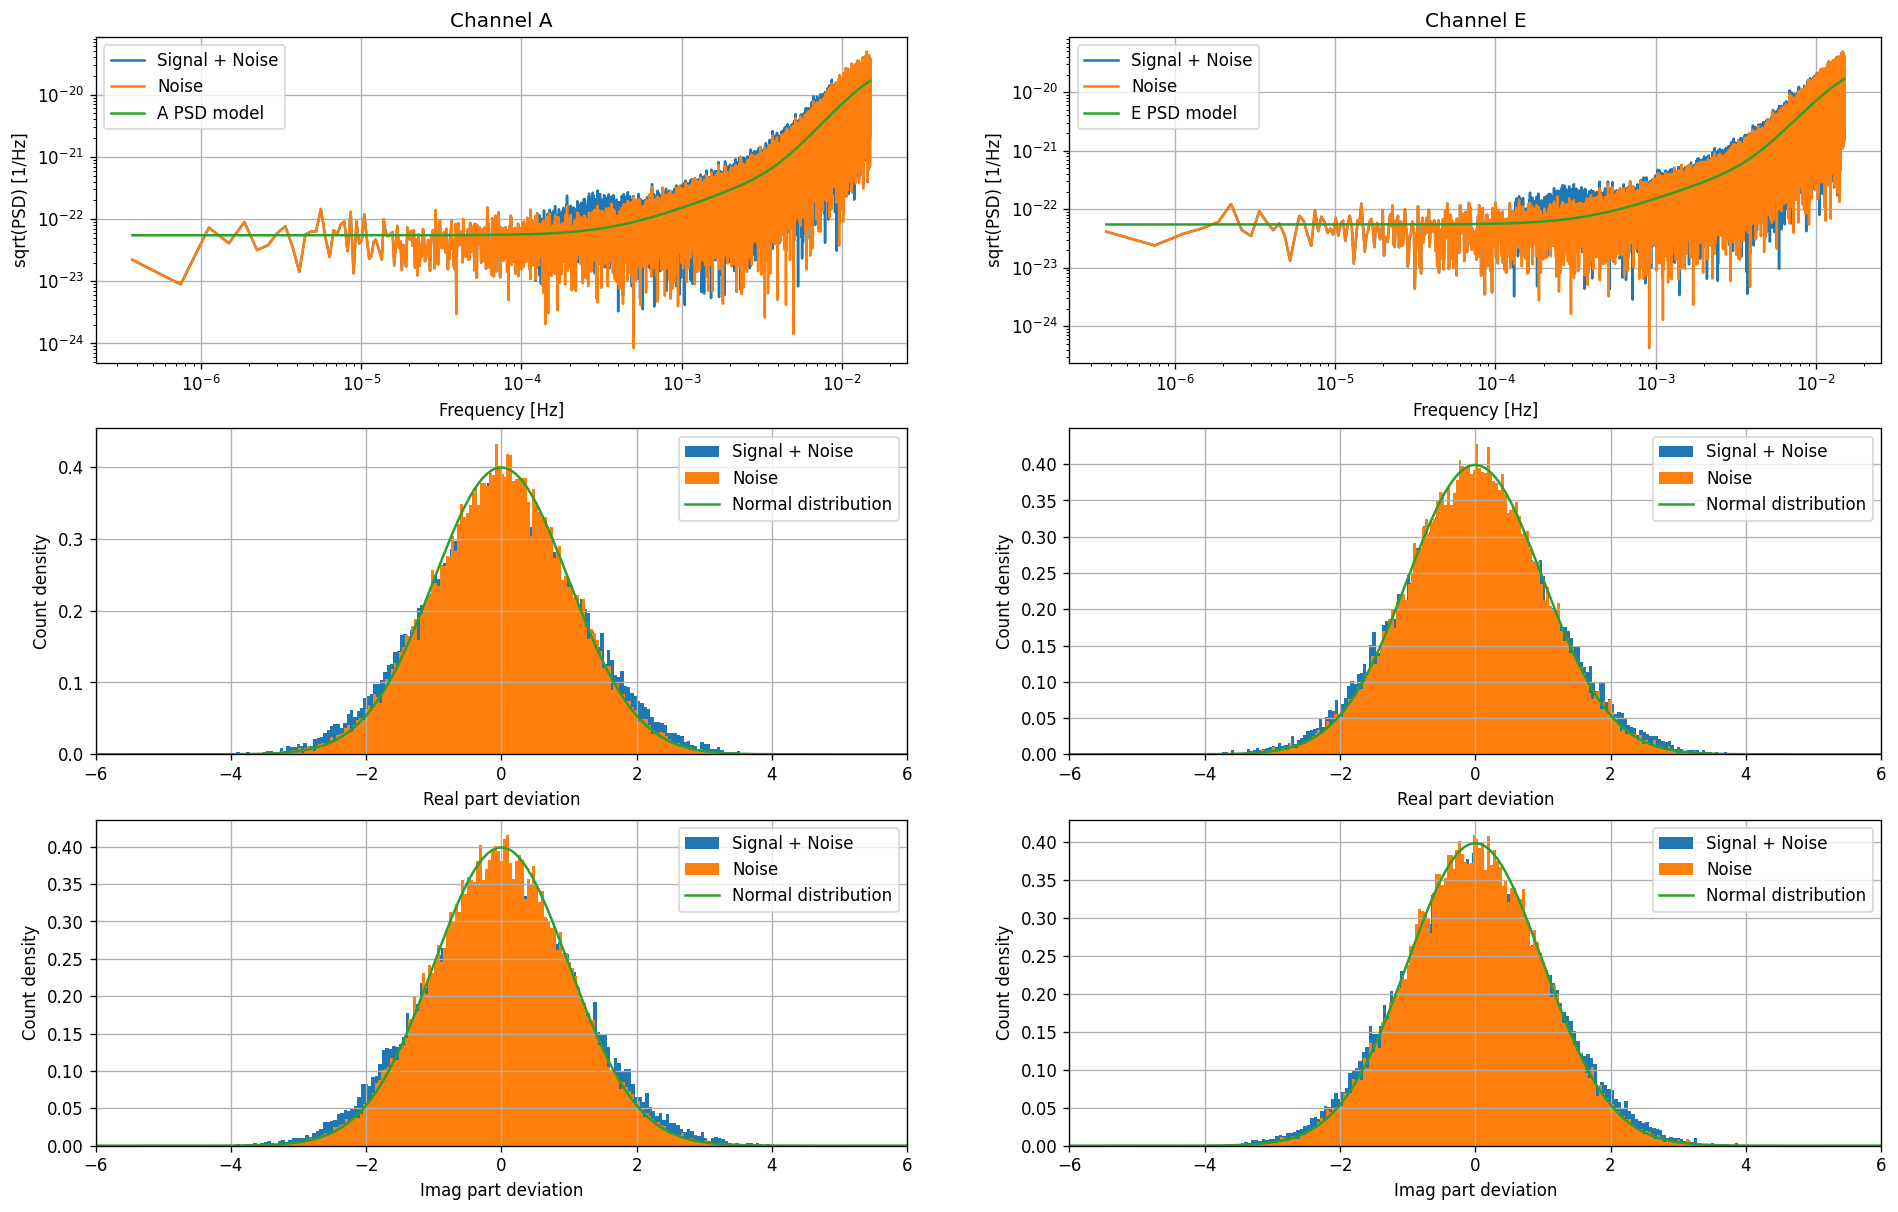

In [20]:
fmax = 1.5e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                noise_models = [S.get(key) for key in ['A','E']], 
                                fmax = fmax)

## 3. Data pre-processing
Trying to apply the same data pre-processing treatment that has been applied to data in `MBHB_search_dev_globe.ipynb`.

We're gonna:
- Downsample and downaverage the data to avoid aliasing
    - Avoid downsampling by selecting single samples
    - Better to be averaging neighboring points

In [21]:
def downaverage(data, factor):
    avg=[]
    # downaveraging step
    for name in data.dtype.names[:]:
        avg += [np.convolve(data[name], np.ones(factor)/factor, mode='valid')] 
#         avg += [data[name]]
    # downsampling with IIR filter to avoid aliasing
    avg[0]=avg[0][::factor]
    for i in range(1,len(avg)):
        avg[i] = scipy.signal.decimate(avg[i], factor)
 
    return np.rec.fromarrays(avg, names = data.dtype.names)

Shape of original data is (535580,) and is downaveraged down to (535580,)


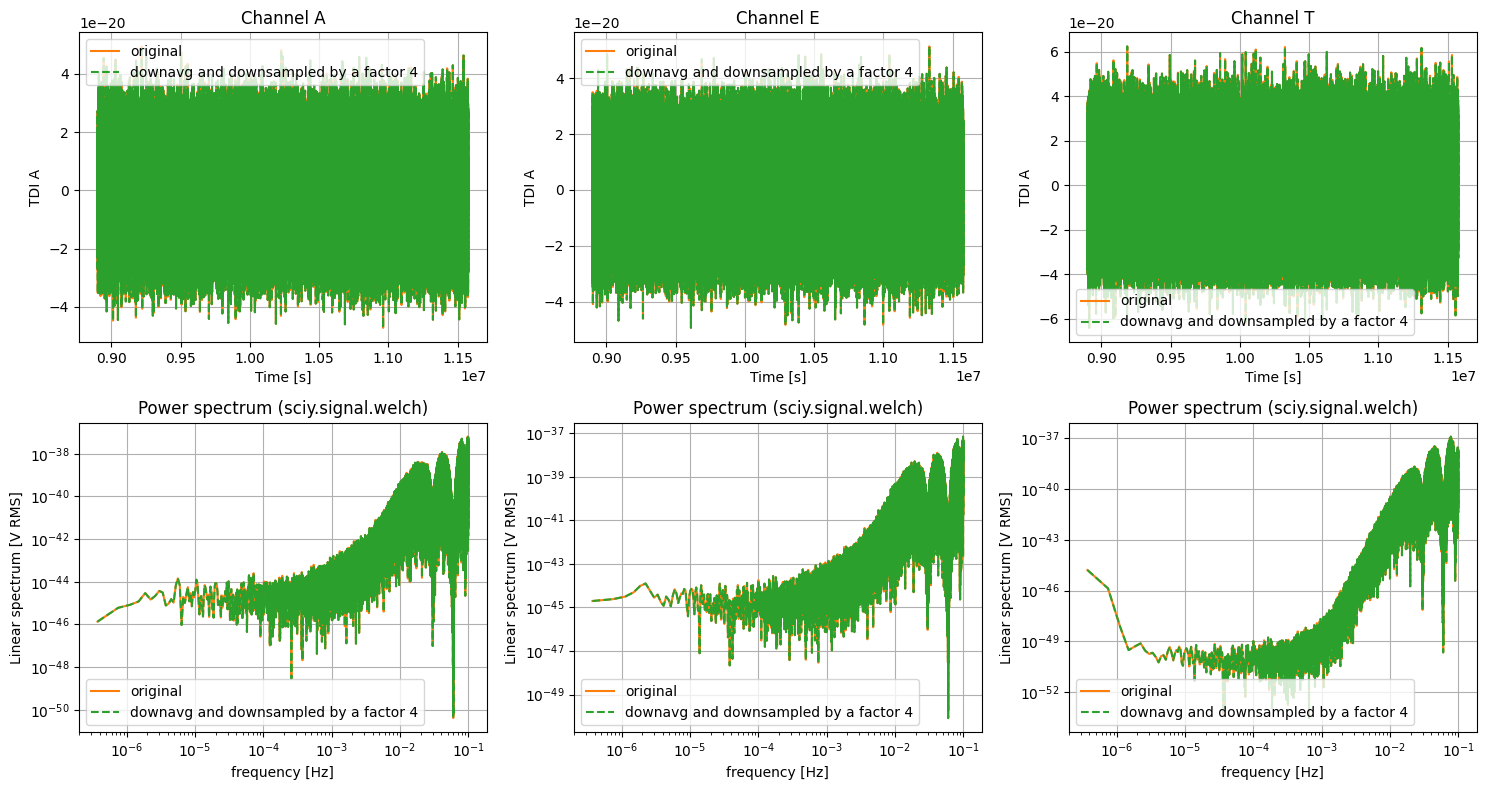

In [22]:
downfactor = 4

# downavg = downaverage(datan,downfactor)
downavg = datan

print("Shape of original data is " + str(datan.shape) + " and is downaveraged down to " + str(downavg.shape))

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

fig, ax = plt.subplots(2,3,figsize=(15,8))

for tdi in S.keys(): 
    ax[0][list(S.keys()).index(tdi)].set_title('Channel {tdi}'.format(tdi=tdi))
    ax[0][list(S.keys()).index(tdi)].plot(datan['t'],datan[tdi], label = 'original',color='tab:orange')
    ax[0][list(S.keys()).index(tdi)].plot(downavg['t'],downavg[tdi],label = 'downavg and downsampled by a factor {0:d}'.format(downfactor),ls='--', color='tab:green')
    ax[0][list(S.keys()).index(tdi)].grid()
    ax[0][list(S.keys()).index(tdi)].legend()
    ax[0][list(S.keys()).index(tdi)].set_xlabel('Time [s]')
    ax[0][list(S.keys()).index(tdi)].set_ylabel('TDI A')

    ax[1][list(S.keys()).index(tdi)].loglog(psddatan['f'], (psddatan[tdi]), label = 'original', ls='-', color='tab:orange')
    ax[1][list(S.keys()).index(tdi)].loglog(psddatan_da['f'], (psddatan_da[tdi]), label = 'downavg and downsampled by a factor {0:d}'.format(downfactor), ls='--', color='tab:green')
    ax[1][list(S.keys()).index(tdi)].set_xlabel('frequency [Hz]')
    ax[1][list(S.keys()).index(tdi)].set_ylabel('Linear spectrum [V RMS]')
    ax[1][list(S.keys()).index(tdi)].set_title('Power spectrum (sciy.signal.welch)')
    ax[1][list(S.keys()).index(tdi)].legend()
#     ax[1][list(S.keys()).index(tdi)].set_xlim([f[0], dt/2])
    ax[1][list(S.keys()).index(tdi)].grid()
fig.tight_layout()

## 4. Gap imputation with custom gaps

In [23]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

In [24]:
n_gaps = 3
gap_length = 1000
figname = 'figures/nodownavg_'+str(n_gaps)+'gaps_'+str(gap_length)+'length'+'_psdoriginal'

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data do not deviate significantly from the Gaussian behavior for the orthogonal TDI combinations.

We have the expected Gaussian distribution behavior for $A$ and $E$, but not as much for $T$.

### 4.1 Noise-only `n` data
We'll first apply imputation to noise-only `n` data, then we'll move to `n + s`. 

We'll use downaveraged data to analyze this problem: instead of `datan` we'll use `datan_da`.
#### 4.1.1 Specify some short gaps and generate gapped data
Based on the `n` data, we are going to add some gaps to this data realization.

We're going to start with 3 small gaps 20-sample 100-seconds long as in the original notebook to test the code.

In [25]:
# reset time-series information data
ndata = downavg.shape[0]
dt = downavg['t'][1]-downavg['t'][0]
fs = 1/(downavg['t'][1]-downavg['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

ndata	dt	fs
---------------------
535580	5.0	0.2


In [26]:
#construct gap mask
mask = np.ones(ndata)
ts = np.arange(ndata) * dt

maskinfo = construct_gap_mask(ndata,
                              n_gaps = n_gaps,
                              gap_length = gap_length,
                              verbose = True)
mask = maskinfo['mask']

Defined gaps:
  gap0 (155273:156273)
  gap1 (305885:306885)
  gap2 (21987:22987)


In [27]:
data_masked = downavg.copy()

for names in downavg.dtype.names[1:]:
    data_masked[names] = mask * downavg[names]

for i in range(len(maskinfo['starts'])):
    print('gap', i,
          ':\n\tsamples:', maskinfo['starts'][i],
          '< i <', maskinfo['ends'][i], 
          '\n\tseconds:', ts[maskinfo['starts'][i]],
          '< t <', ts[maskinfo['ends'][i]])

gap 0 :
	samples: 155273 < i < 156273 
	seconds: 776365.0 < t < 781365.0
gap 1 :
	samples: 305885 < i < 306885 
	seconds: 1529425.0 < t < 1534425.0
gap 2 :
	samples: 21987 < i < 22987 
	seconds: 109935.0 < t < 114935.0


#### 4.1.2. Define function to visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [28]:
from bayesdawn.connect.fillgaps import view_gaps

In [29]:
ratio = np.zeros((2,3))
ratio

array([[0., 0., 0.],
       [0., 0., 0.]])

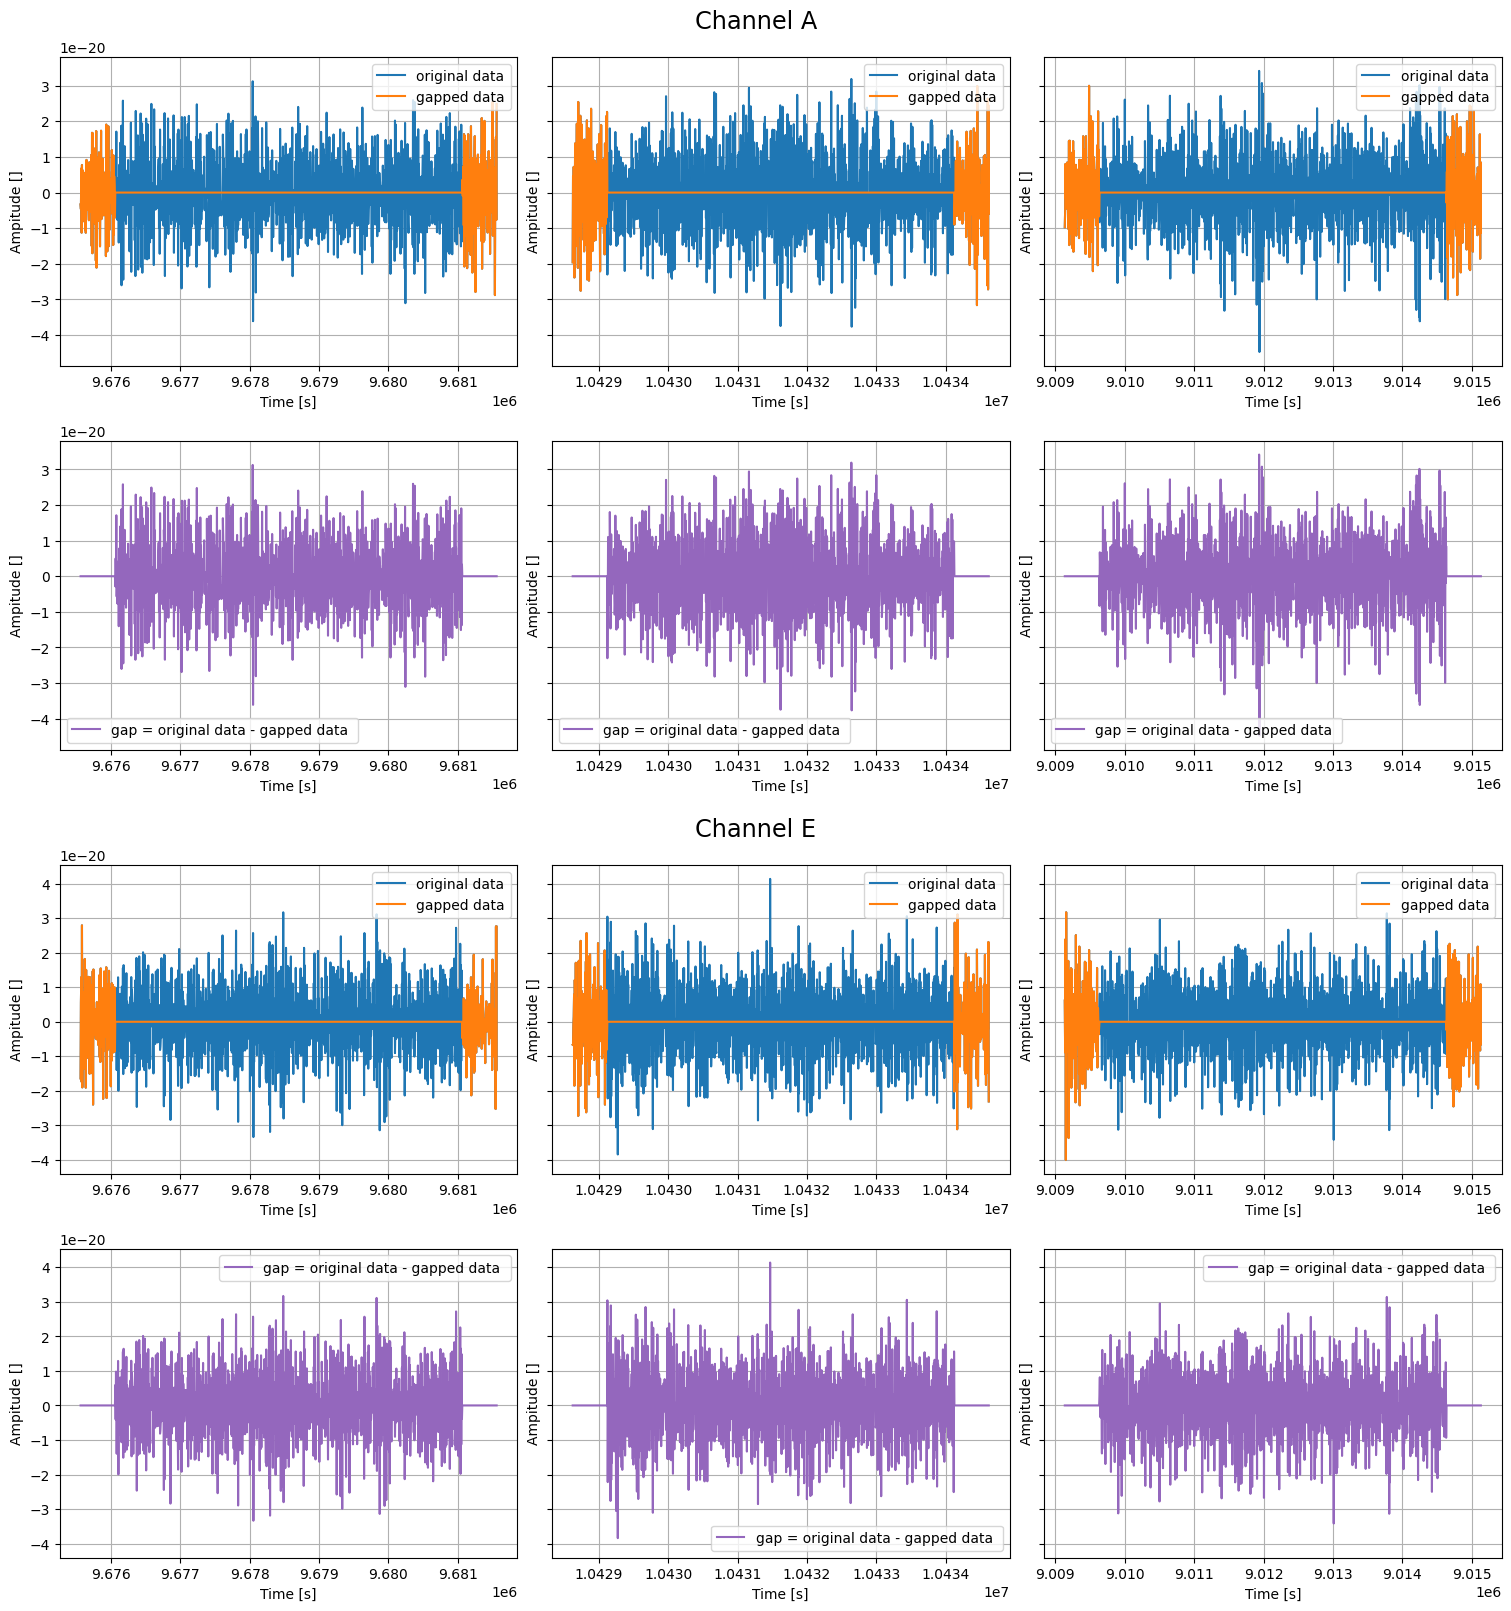

In [30]:
view_gaps(ts = downavg['t'],
          ys = [[downavg[names] for names in downavg.dtype.names[1:]]],
          yg = [data_masked[names] for names in downavg.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data'])

#### 4.1.3 Set up PSD Spritz noise model

We'll end up not using this noise model in the gap imputation, but this might be useful for other purposes (or once the Spritz noise model is fixed).

In [31]:
from bayesdawn.connect.fillgaps import LDCModelPSD

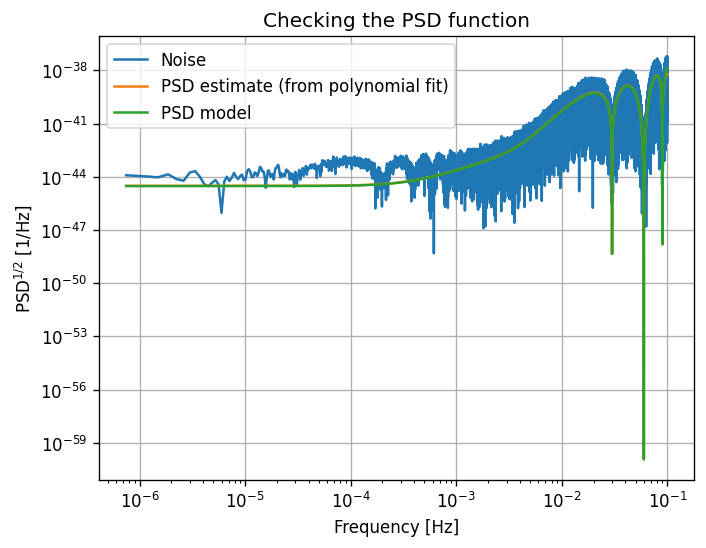

In [32]:
# define tdi names
names = ['A', 'E', 'T']
# create empty arrays
psd_estimate=[]
psd_estimate_gaps=[]
# evaluate fft and periodograms
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)
fdatan_m, psddatan_m, fftscalefac_m = generate_freq_data(data_masked)
#evaluate psd model
Nmodel = get_noise_model(noise_model, fdatan_da['f'])
for tdi in names:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_da['f'][1:])
# perform PSD estimation

# tdi = 'A'
# x = psddatan_m['f'][1:]
# y = np.log(psddatan_m[tdi][1:]/S[tdi])
# pf = np.polyfit(x,y,5)
# psdmodel.fit_lsqr(y)

pf = np.array([-2.06121949e+06,  4.20988173e+05, -2.88082710e+04,  7.11239347e+02,
       -3.23216923e+00,  1.02536420e+00])
poly = np.poly1d(pf)
# Plot data against PSD
fig, ax = plt.subplots(dpi=120)
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax.loglog(psddatan_da['f'][1:], (psddatan_m['A'][1:]), label="Noise")
ax.loglog(psddatan_da['f'][1:], np.abs(poly(psddatan_m['f'][1:])*S['A']), label="PSD estimate (from polynomial fit)")
ax.loglog(psddatan_da['f'][1:], S['A'], label="PSD model")
ax.grid()
plt.legend()
plt.show()
# np.abs(spl(psddatan_da['f'][1:]))

Let's take a look at the model w.r.t downaveraged data.

#### 4.1.5. Perform data imputation on `n` data with custom short gaps

Let's start by creating the imputation iterative step.

The imputation script is structured as follows:

    # generate the boolean mask of gaps
    maskinfo = fill_gaps.construct_gap_mask(ndata,
                                  n_gaps = 3,
                                  gap_length = 100,
                                  verbose = True)
    mask = maskinfo['mask']
    # for residual 'signal' is zero
    # where the complete data are y = s + n 
    s = np.zeros(len(mask)) 
    y_masked = mask * y
    # here we declare the psd class
    #### psd_cls = ....
    # initialize the imputation class
    imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=50*fs, nb=50*fs)
    # Initialize the (reconstructed) data residuals
    imp_cls.compute_offline() ### this was the line that was missing and that triggers an error when starting with psd_cls = PSDSpline(...)
    y_res = y_masked
        for i in range(n_iter):
            # here we might have a step for updating the PSD with updated y_res data
            #### psd_cls = .... update
            # Pass the updated PSD model to the imputation class
            imp_cls.update_psd(psd_cls)
            # Re-compute of PSD-dependent terms
            imp_cls.compute_offline()
            # Imputation of missing data by randomly drawing from their conditional distribution
            y_res = imp_cls.impute(y_masked, draw=True)

In [33]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_CORRECTION = False
data_rec = data_masked.copy()
    
# instantiate the PSD noise class
if PSD_CORRECTION:
    for tdi in names:
        psd_cls.append(LDCCorrectedModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
else:
    for tdi in names:
        psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, fmax = 15e-3))
    
    
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = data_masked[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50*fs, nb=50*fs)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
    t1 = time.time()
    imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_res = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    t2 = time.time()
    print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
    data_rec[names[tdi]] = y_res

NameError: name 'ndata' is not defined

Now let's take a look at each gap after imputation: We're going to compare original, gapped and reconstructed data.

In [ ]:
view_gaps(ts = downavg['t'],
          ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                [data_rec[names] for names in downavg.dtype.names[1:]]],
          yg = [data_masked[names] for names in downavg.dtype.names[1:]],
          maskinfo = maskinfo, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = True, fname = figname)

Regenerate noise models and plot original and reconstructed noise spectra and the distribution of real/imag part of the whitened data.

In [ ]:
fdatan_rec, psddata_rec, _ = generate_freq_data(data_rec) 

In [ ]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
# plot comparison
plot_compare_spectra_timeseries(data = [downavg, data_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Downavg original noise', 'Reconstructed noise'], save = True, fname = figname)

Proceed by plotting spectra and real/imag part histograms of the gaps alone.

Firstly, let's create a time-series of gaps alone.

In [ ]:
# gaps_rec = data_rec.copy()
# gaps_orig = downavg.copy()

# for names in data_rec.dtype.names[1:]:
#     gaps_rec[names] = np.abs(mask - 1) * data_rec[names]
#     gaps_orig[names] = np.abs(mask - 1) * downavg[names]

In [ ]:
# # noise models for A, E, T 
# # noise_model = "spritz"
# # S = {}
# # Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
# # for tdi in ['A', 'E', 'T']:
# #     S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
# # plot comparison
# plot_compare_spectra_timeseries(data = [gaps_orig,gaps_rec], 
#                                 noise_models = [S.get(key) for key in ['A','E']],
#                                 fmax = 1.5e-2,
#                                labels = ['Downavg original noise', 'Reconstructed noise'], save = False)

Run the analysis again, but this run some tests on the quality of imputation depending on the chosen PSD model:
- Original LDC noise model  $S(f)$
- Corrected LDC noise model $S_{corr}(f) = p(f) S(f)$ where $p(f)$ is a 5th degree polynomial fit to $\frac{PSD_{exp}(f)}{S(f)}$

In [ ]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_CORRECTION = False
SAVE = True
data_rec = data_masked.copy()
std_ratios = []
names = ['A', 'E']

#for i in range(10):
for i in range(0):
    fignameiter = figname +'_iter'+str(i)
    # instantiate the PSD noise class
    if PSD_CORRECTION:
        for tdi in names:
            psd_cls.append(LDCcorrectedmodelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, polyfit = poly))
    else:
        for tdi in names:
            psd_cls.append(LDCModelPSD(ndata, fs, noise_model = 'spritz', channel = tdi, fmax = 15e-3))


    # Perform data imputation
    ### NB this can be streamlined a little bit more and/or transformed into a function 
    for tdi in range(len(names)):
        y_masked = data_masked[names[tdi]]
        s = np.zeros(len(mask))  #for residual 'signal' is zero
        # instantiate imputation class
        imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50*fs, nb=50*fs)]
        # Initialize the (reconstructed) data residuals
        y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)   
        t1 = time.time()
        imp_cls[tdi].update_psd(psd_cls[tdi])
        # Re-compute of PSD-dependent terms
        imp_cls[tdi].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        y_res = imp_cls[tdi].impute(y_masked, draw=True)
        # Update the data residuals
        t2 = time.time()
        print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))
        data_rec[names[tdi]] = y_res

    std = view_gaps(ts = downavg['t'],
              ys = [[downavg[names] for names in downavg.dtype.names[1:]], 
                    [data_rec[names] for names in downavg.dtype.names[1:]]],
              yg = [data_masked[names] for names in downavg.dtype.names[1:]],
              maskinfo = maskinfo, channels = ['A', 'E'],
              labels=['original data', 'reconstructed data', 'gapped data'],
              save = SAVE, fname = fignameiter)
    std_ratios += [std]
    
    fdatan_rec, psddata_rec, _ = generate_freq_data(data_rec) 

    # noise models for A, E, T 
    noise_model = "spritz"
    S = {}
    Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
    for tdi in ['A', 'E', 'T']:
        S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])
    # plot comparison
    plot_compare_spectra_timeseries(data = [downavg, data_rec], 
                                    noise_models = [S.get(key) for key in ['A','E']],
                                    fmax = 1.5e-2,
                                   labels = ['Downavg original noise', 'Reconstructed noise'], save = SAVE, fname = fignameiter)

Plot the histogram of standard deviation ratio

In [ ]:
ratio = []
for i in range(len(std_ratios)):
    ratio += [std_ratios[i][1]/std_ratios[i][0]]

print(ratio)
fig, ax = plt.subplots(1,1,dpi=120)
ax.hist(ratio)

## 5. Gap imputation with unknown noise

In the above we performed imputation with the benefit of auxiliary information about the noise PSD.  In particular we either started with an analytic PSD model or derived a model based on known "ungapped" data.  Thus, we cheated, as these processes cannot be applied to real gapped data, or the nominal Spritz dataset.

Still working with noise-only data, here we will infer the PSD and the missing data together.  The way we did this in the 2019 paper applied a parameterized model for the PSD which was inferred by Bayesian inference using MCMC. As a simpler first step, here we will apply a maximum likelihood PSD, effectively applying an expectation-maximization algorithm. 

Here we understand "maximum likelihood" loosely.  Generally for Gaussian noise, with unknown covariance, the maximum likelihood covariance is the sample covariance (computed a particular way) of the noise residual. We apply that result only as a rough principle and instead just compute a (in some way) best fit modeled PSD.

Various PSD models may make sense here.  The model could be fit directly to the residual spectrum/PSD or (as is already done above) we can fit to a ratio of the computed PSD over an analytic model.  Different versions of that analytic model can also make sense.  In particular, it may be worthwhile to smooth the dips.  The model function may be, for example, a polyfit or a smoothed spline.  One can also consider whether it makes more sense to fit the PSD (which has approximate zeros), or its inverse (which appears directly in the likelihood computation).

We implement this in a new class ModelFDDataPSD bayesdawn/connect/fillgaps.py. 

Note: Long-term, it probably makes sense to eventually fold the functionality here into the underlying
    bayesdawn.psdmodel.PSD code, which already includes a MCMC sampled spline fit for the PSD. Missing
    there is the crutch we use here for starting from, and scaling against an approximate analytic model.

MLDC modules could not be loaded.


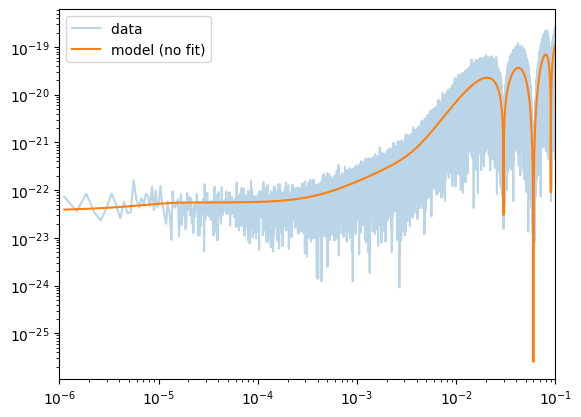

log_poly


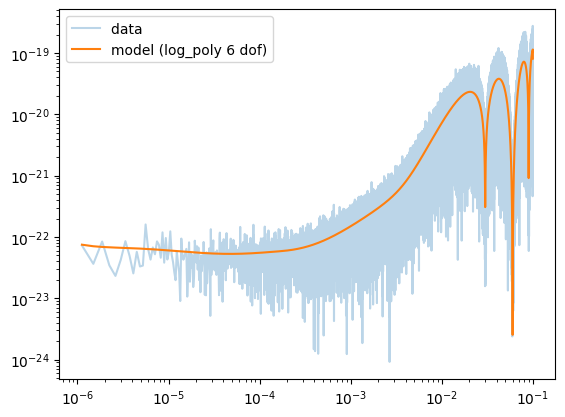

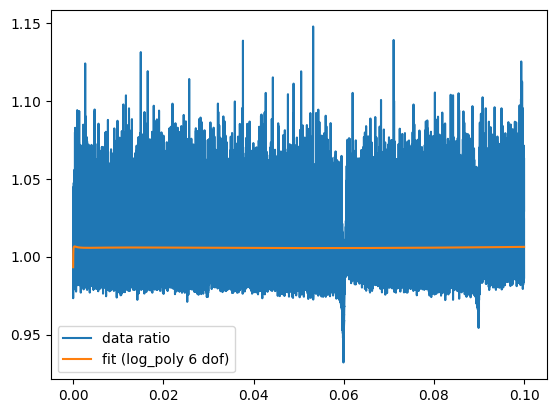

/tmp/ipykernel_2426188/2716331199.py:29: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=minf)


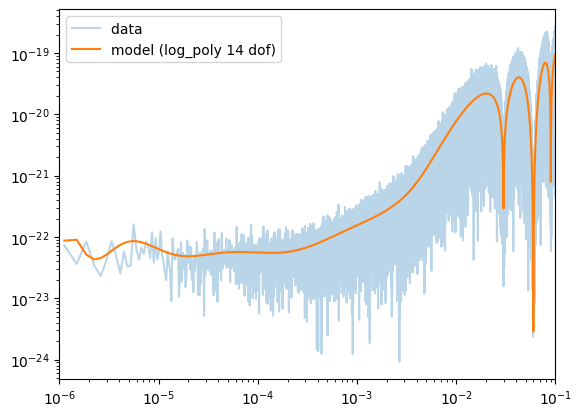

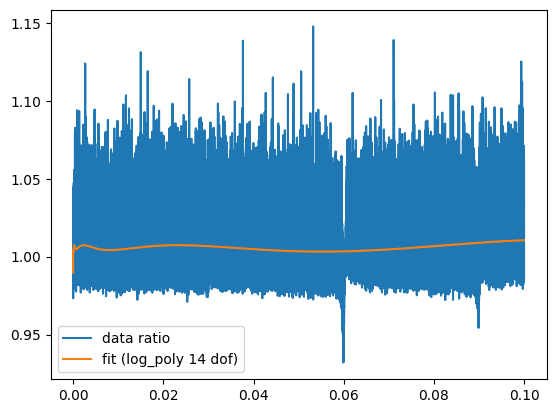

log_spline
1.1202808170581427e-06 < f <  0.1 fmin/fmax= 1e-06 None
base= 2.2574571068187965
lowest f knots: [2.52898589e-06 5.62550460e-06 1.23335507e-05 2.66587766e-05
 5.68237103e-05]


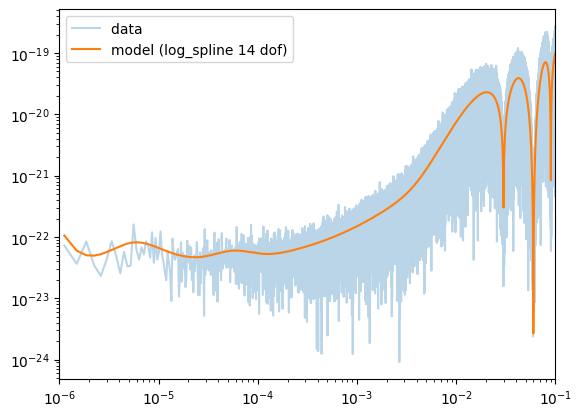

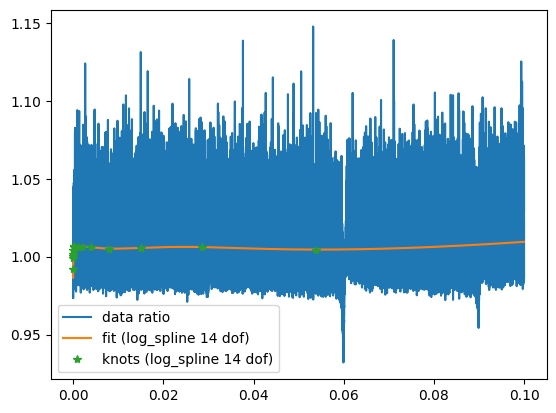

1.1202808170581427e-06 < f <  0.1 fmin/fmax= 1e-06 None
base= 1.7682092372585703
lowest f knots: [3.48431446e-06 6.09702830e-06 1.06141178e-05 1.83837873e-05
 3.16804854e-05]


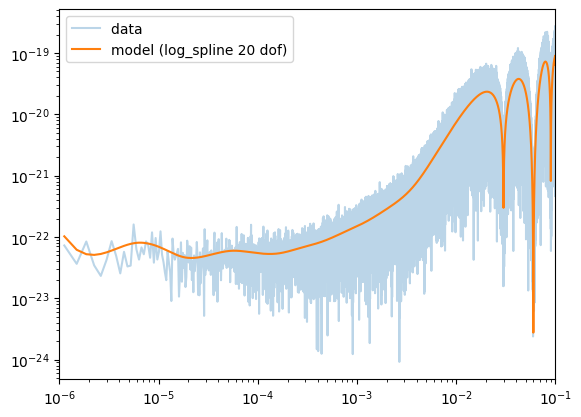

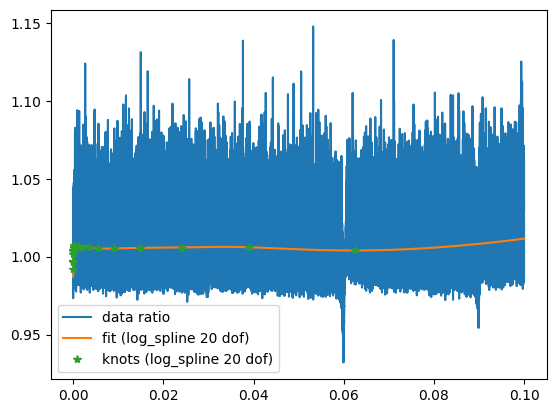

spline no analytic model
1.1202808170581427e-06 < f <  0.1 fmin/fmax= 1e-06 None
base= 1.4622527159537209
lowest f knots: [1.63813367e-06 2.39154230e-06 3.48590869e-06 5.07301400e-06
 7.37107993e-06]


(1e-06, 0.1)

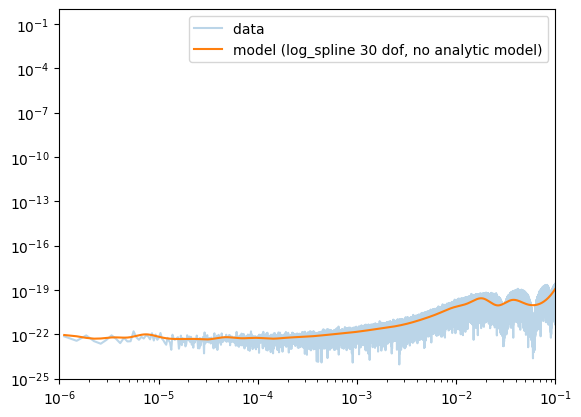

In [50]:
import importlib
import bayesdawn.connect.fillgaps as fillgaps
importlib.reload(fillgaps)
importlib.reload(psdmodel)
fd=fillgaps.makeFDdata(build_orthogonal_tdi(tdi_noise))
#ModelPSD=ModelFDDataPSD
ModelPSD=psdmodel.ModelFDDataPSD
show_fit=True
lims=(None,None)
#lims=(0.029,0.062)
lims=(1e-6,.1)
minf=1e-6
#psdmod=ModelPSD(fd,'A',fit_type=None,fmin=minf)
#psdmod.plot()
#psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-6,fmin=minf)
#psdmod.plot()
psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-5,fmin=minf)
psdmod.plot()
plt.xlim(*lims)
plt.show()
#print('poly')
#psdmod=ModelPSD(fd,'A',fit_type='poly',fit_dof=4,smooth_df=4e-4,fmin=minf)
#psdmod.plot(show_fit=show_fit)
print('log_poly')
psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=6,smooth_df=4e-4,fmin=minf)
psdmod.plot(show_fit=show_fit,tag='log_poly 6 dof')
plt.xlim(*lims)

psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=minf)
psdmod.plot(show_fit=show_fit,tag='log_poly 14 dof')
plt.xlim(*lims)

if not show_fit:plt.show()
print('log_spline')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=14,smooth_df=4e-4,fmin=minf)
psdmod.plot(show_fit=show_fit,tag='log_spline 14 dof')
plt.xlim(*lims)
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=20,smooth_df=4e-4,fmin=minf)
psdmod.plot(show_fit=show_fit,tag='log_spline 20 dof')
plt.xlim(*lims)
plt.ylim(1e-25,None)

if False:
    print('spline')
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=30,smooth_df=4e-4,fmin=minf)
    psdmod.plot(show_fit=show_fit,tag='spline 30 dof')
    plt.xlim(*lims)
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=60,smooth_df=4e-4,fmin=minf)
    psdmod.plot(show_fit=show_fit,tag='spline 60 dof')
    plt.xlim(*lims)
    plt.ylim(1e-25,None)
    plt.show()
print('spline no analytic model')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',noise_model=None,fit_dof=30,fmin=minf)
psdmod.plot(show_fit=show_fit,tag='log_spline 30 dof, no analytic model')
plt.xlim(*lims)

In [49]:
(psdmod.psd_fn(psdmod.fin))

array([8.93557609e-45, 3.91665725e-45, 3.46126738e-45, ...,
       1.43736441e-38, 1.43747615e-38, 1.43758791e-38])

## 6. Analysis of Spritz gapped data